Dieses Notebook baut auf der Einführung im "basic_tutorial"-Notebook auf und stellt Techniken zur Erhöhung der Vorhersagegenauigkeit und der Beschleunigung des Trainings vor

Für Bilddaten liefern [Convolutional Neural Networks](https://de.wikipedia.org/wiki/Convolutional_Neural_Network) (CNN oder ConvNet) die höchste Vorhersagegenauigkeit.
CNNs verwenden Filter um durch mathematische Faltung (engl. "convolution") Eigenschaften eines Bildes hervorzuheben.
Nach jeder Convolutional Layer (ConvLayer) wird ein Pooling verwendet mit dem die Auflösung des Bildes sukzessiv reduziert wird (siehe Abb.).
Üblicherweise werden innerhalb einer Convolutional Layer eines CNNs parallel mehrere Faltungen mit verschiedenen Filtern durchgeführt (Anzahl an Channels), sodass nach der letzten Kombination von Convolution und Pooling Layer viele mehrfach gefilterte, niedrigaufgelöste Versionen des Eingangsbilds exisitieren.
Alle Pixel dieser Versionen werden als ein langer Vektor durch ein vollständig verbundenes neuronales Netz (DenseNet), wie wir es aus dem basic_tutorial kennen, auf die Ziffern 0 bis 9 abgebildet.

<img src="cnn.png" style="width:800px;height:400px;">

Es wird wieder Version 2 von [fastai](https://docs.fast.ai/) (Installationsanleitung inkl. PyTorch im Link) verwendet.

Packages werden importiert

In [10]:
from fastai.basics import *
from fastai.vision.all import *

MNIST-Daten werden heruntergeladen und als [ImageDataLoader-Objekt](https://docs.fast.ai/vision.data.html#ImageDataLoaders) geladen

Durch [Data Augmentation](https://docs.fast.ai/vision.augment.html) kann die Anzahl an Trainingsdaten künstlich erhöht werden, indem die Bilder gedreht, gezoomt, verschoben,... werden.

Diese Transformationen können als batch_tfms übergeben werden.

In diesem Fall werden eine Reihe von sinnvollen Transformationen durch die Funktion [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) übergeben

In [11]:
path = untar_data(URLs.MNIST)
data = ImageDataLoaders.from_folder(path, train='training', valid='testing', bs=64, batch_tfms=aug_transforms())

Mit .show_batch() werden die Transformationen der Originalbilder deutlich

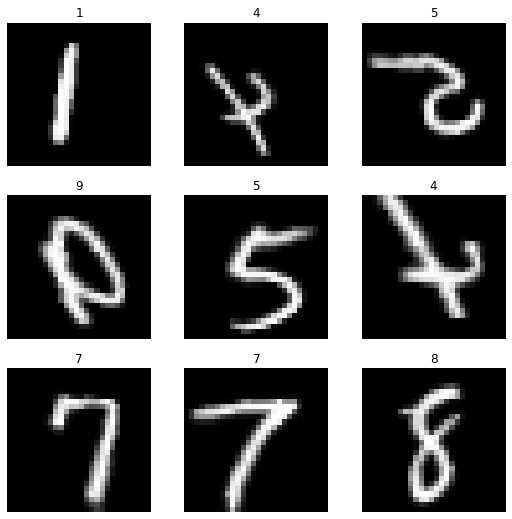

In [12]:
data.show_batch()

Initialisierung eines kleinen CNNs mit zwei ConvLayern [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

Nach jeder ConvLayer wird ein [Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) durchgeführt.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

cnn_model = Net()
cnn_learn = Learner(data, cnn_model, metrics=accuracy)
print(cnn_learn.summary())

Net (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 24 x 24    
Conv2d                                    608        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    3216       True      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 10             
Linear                                    1210       True      
____________________________________________________________________________

Total params: 35,874
Total trainable params: 35,874
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7ff7c7281430>
Loss function: FlattenedLoss of CrossEntropyLoss

Mit [.lr_find](https://fastai1.fast.ai/callbacks.lr_finder.html#lr_find) kann eine vernünftige Learning Rate bestimmt werden.

Dabei wird bei einem Probetraining die Learning Rate erhöht und die Learning Rate bei der der Loss am stärksten fällt, ist eine gute Wahl für das richtige Training.

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.013182567432522774)

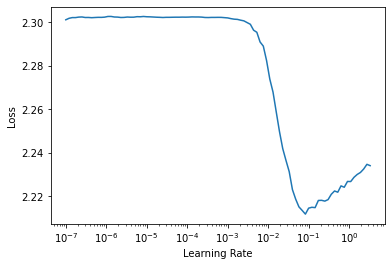

In [14]:
cnn_learn.lr_find()

Neben dieser steilsten Learning Rate (lr_steep), wird kann auch eine lr_min vorgeschlagen.
Dies ist 10% der Learning Rate der Minimalstelle des find_lr-Plots. In unserem Fall wählen wir lr_min $= 7*10^{-3}$ als Learning Rate

Statt .fit wird häufig [.fit_one_cycle](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle) verwendet um die Konvergenz des Losses zu beschleunigen.

In [15]:
cnn_learn.fit_one_cycle(3, 7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.571280,1.521113,0.910400,00:10
1,1.522095,1.488184,0.964700,00:09
2,1.500926,1.481199,0.975400,00:10


Mit diesem einfachen CNN kommen wir auf eine Genauigkeit von ca. 97%.

Mit dem Einsatz von Transfer Learning ist es möglich diese Genauigkeit noch weiter zu steigern.

Dazu wird ein CNN als Modell verwendet welches bereits auf einer großen Anzahl von Bildern in einer anderen Domäne trainiert wurde

Hier hilft uns die Funktion [cnn_learner](https://docs.fast.ai/vision.learner.html#cnn_learner) mit der vortrainierte Modelle wie das [xresnet18](https://docs.fast.ai/vision.models.xresnet.html#xresnet18) in einer Zeile geladen werden können

In [16]:
cnn_learn = cnn_learner(data, resnet18, metrics=accuracy, pretrained=True)
print(cnn_learn.summary())

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 14 x 14   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

Wie man sehen kann ist dies ein deutlich tieferes CNN als unser selbstgebasteltes CNN.

Es wird wieder eine vernünftige Learning Rate gesucht

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.001737800776027143)

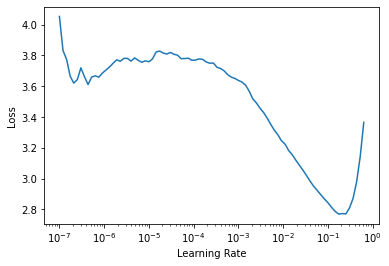

In [17]:
cnn_learn.lr_find()

Wir wählen $1*10^{-2}$ als Learning Rate

In [ ]:
cnn_learn.fit_one_cycle(10, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.358288,0.201268,0.937600,00:22
1,0.254615,0.120493,0.961600,00:21
2,0.227194,0.142599,0.956900,00:22
3,0.181067,0.098230,0.967400,00:22
4,0.155261,0.084949,0.972900,00:22
5,0.109499,0.082300,0.975900,00:22
6,0.109943,0.062260,0.979700,00:22


Mit dem vortrainierten Netz ist im ersten Anlauf eine Genauigkeit von 98,4% möglich.

Durch Austesten verschiedener Parameter kann die Genauigkeit weiter erhöht werden. Try it!